In [1]:
#| default_exp common._base_auto

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

# Hyperparameter Optimization

> Machine Learning forecasting methods are defined by many hyperparameters that control their behavior, with effects ranging from their speed and memory requirements to their predictive performance. For a long time, manual hyperparameter tuning prevailed. This approach is time-consuming, **automated hyperparameter optimization** methods have been introduced, proving more efficient than manual tuning, grid search, and random search.<br><br> The `BaseAuto` class offers shared API connections to hyperparameter optimization algorithms like [Optuna](https://docs.ray.io/en/latest/tune/examples/bayesopt_example.html), [HyperOpt](https://docs.ray.io/en/latest/tune/examples/hyperopt_example.html), [Dragonfly](https://docs.ray.io/en/latest/tune/examples/dragonfly_example.html) among others through `ray`, which gives you access to grid search, bayesian optimization and other state-of-the-art tools like hyperband.<br><br>Comprehending the impacts of hyperparameters is still a precious skill, as it can help guide the design of informed hyperparameter spaces that are faster to explore automatically.

![Figure 1. Example of dataset split (left), validation (yellow) and test (orange). The hyperparameter optimization guiding signal is obtained from the validation set.](imgs_models/data_splits.png)

In [3]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [4]:
#| export
from copy import deepcopy
from os import cpu_count

import torch
import pytorch_lightning as pl

from pytorch_lightning.callbacks import TQDMProgressBar
from ray import air, tune
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.search.basic_variant import BasicVariantGenerator

from neuralforecast.losses.pytorch import MAE

In [5]:
#| export
class BaseAuto(pl.LightningModule):
    """ BaseAuto 

    Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to 
    give access to a wide variety of hyperparameter optimization tools ranging 
    from classic grid search, to Bayesian optimization and HyperBand algorithm.

    The validation loss to be optimized is defined by the `config['loss']` dictionary
    value, the config also contains the rest of the hyperparameter search space.

    It is important to note that the success of this hyperparameter optimization
    heavily relies on a strong correlation between the validation and test periods.

    **Parameters:**<br>
    `cls_model`: PyTorch/PyTorchLightning model, see `neuralforecast.models` [collection here](https://nixtla.github.io/neuralforecast/models.html).<br>
    `h`: int, forecast horizon.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `config`: dict, dictionary with ray.tune defined search space.<br>
    `search_alg`: ray.tune.search variant, BasicVariantGenerator, HyperOptSearch, DragonflySearch, TuneBOHB for details
        see [tune.search](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#).<br>
    `num_samples`: int, number of hyperparameter optimization steps/samples.<br>
    `cpus`: int, number of cpus to use during optimization, default all available.<br>
    `gpus`: int, number of gpus to use during optimization, default all available.<br>
    `refit_wo_val`: bool, number of gpus to use during optimization, default all available.<br>
    `verbose`: bool, wether print partial outputs.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    """
    def __init__(self, 
                 cls_model,
                 h,
                 loss,
                 valid_loss,
                 config, 
                 search_alg=BasicVariantGenerator(random_state=1),
                 num_samples=10,
                 cpus=cpu_count(),
                 gpus=torch.cuda.device_count(),
                 refit_with_val=False,
                 verbose=False,
                 alias=None):
        super(BaseAuto, self).__init__()
        self.save_hyperparameters() # Allows instantiation from a checkpoint from class

        if config.get('h', None) is not None:
            raise Exception("Please use `h` init argument instead of `config['h']`.")
        if config.get('loss', None) is not None:
            raise Exception("Please use `loss` init argument instead of `config['loss']`.")
        if config.get('valid_loss', None) is not None:
            raise Exception("Please use `valid_loss` init argument instead of `config['valid_loss']`.")

        # Deepcopy to avoid modifying the original config
        config_base = deepcopy(config)

        # Add losses to config and protect valid_loss default
        config_base['h'] = h
        config_base['loss'] = loss
        if valid_loss is None:
            valid_loss = loss
        config_base['valid_loss'] = valid_loss
        
        self.h = h
        self.cls_model = cls_model
        
        self.config = config_base
        self.loss = self.config['loss']
        self.valid_loss = self.config['valid_loss']

        self.num_samples = num_samples
        self.search_alg = search_alg
        self.cpus = cpus
        self.gpus = gpus
        self.refit_with_val = refit_with_val
        self.verbose = verbose
        self.alias = alias

        # Base Class attributes
        self.SAMPLING_TYPE = cls_model.SAMPLING_TYPE
    
    def __repr__(self):
        return type(self).__name__ if self.alias is None else self.alias
    
    def _train_tune(self, config_step, cls_model, dataset, val_size, test_size):
        """ BaseAuto._train_tune

        Internal function that instantiates a NF class model, then automatically
        explores the validation loss (ptl/val_loss) on which the hyperparameter 
        exploration is based.

        **Parameters:**<br>
        `config_step`: Dict, initialization parameters of a NF model.<br>
        `cls_model`: NeuralForecast model class, yet to be instantiated.<br>
        `dataset`: NeuralForecast dataset, to fit the model.<br>
        `val_size`: int, validation size for temporal cross-validation.<br>
        `test_size`: int, test size for temporal cross-validation.<br>
        """
        metrics = {"loss": "ptl/val_loss"}
        callbacks = [TQDMProgressBar(), TuneReportCallback(metrics, on="validation_end")]
        if 'callbacks' in config_step.keys():
            callbacks += config_step['callbacks']
        config_step = {**config_step, **{'callbacks': callbacks}}
        #model = cls_model(**config_step)
        #model.fit(
        #    dataset,
        #    val_size=val_size, 
        #    test_size=test_size
        #)
        model = self._fit_model(cls_model=self.cls_model,
                                config=config_step,
                                dataset=dataset,
                                val_size=val_size,
                                test_size=test_size)

    def _tune_model(self, cls_model, dataset, val_size, test_size,
                cpus, gpus, verbose, num_samples, search_alg, config):
        train_fn_with_parameters = tune.with_parameters(
            self._train_tune,
            cls_model=cls_model,
            dataset=dataset,
            val_size=val_size,
            test_size=test_size,
        )

        # Device
        if gpus > 0:
            device_dict = {'gpu':gpus}
        else:
            device_dict = {'cpu':cpus}

        tuner = tune.Tuner(
            tune.with_resources(train_fn_with_parameters, device_dict),
            run_config=air.RunConfig(
                verbose=verbose,
                #checkpoint_config=air.CheckpointConfig(
                    #num_to_keep=0,
                    #keep_checkpoints_num=None
                #)
            ),
            tune_config=tune.TuneConfig(
                metric="loss",
                mode="min",
                num_samples=num_samples, 
                search_alg=search_alg
            ),
            param_space=config,
        )
        results = tuner.fit()
        return results
    
    def _fit_model(self, cls_model, config,
                   dataset, val_size, test_size):
        model = cls_model(**config)
        model.fit(
            dataset,
            val_size=val_size, 
            test_size=test_size
        )
        return model

    def fit(self, dataset, val_size=0, test_size=0, random_seed=None):
        """ BaseAuto.fit

        Perform the hyperparameter optimization as specified by the BaseAuto configuration 
        dictionary `config`.

        The optimization is performed on the `TimeSeriesDataset` using temporal cross validation with 
        the validation set that sequentially precedes the test set.

        **Parameters:**<br>
        `dataset`: NeuralForecast's `TimeSeriesDataset` see details [here](https://nixtla.github.io/neuralforecast/tsdataset.html)<br>
        `val_size`: int, size of temporal validation set (needs to be bigger than 0).<br>
        `test_size`: int, size of temporal test set (default 0).<br>
        `random_seed`: int=None, random_seed for hyperparameter exploration algorithms, not yet implemented.<br>
        **Returns:**<br>
        `self`: fitted instance of `BaseAuto` with best hyperparameters and results<br>.
        """
        #we need val_size > 0 to perform
        #hyperparameter selection.
        search_alg = deepcopy(self.search_alg)
        val_size = val_size if val_size > 0 else self.h
        results = self._tune_model(
            cls_model=self.cls_model,
            dataset=dataset,
            val_size=val_size, 
            test_size=test_size, 
            cpus=self.cpus,
            gpus=self.gpus,
            verbose=self.verbose,
            num_samples=self.num_samples, 
            search_alg=search_alg, 
            config=self.config
        )
        best_config = results.get_best_result().config
        #self.model = self.cls_model(**best_config)
        #self.model.fit(
        #    dataset=dataset, 
        #    val_size=val_size * (1 - self.refit_with_val), 
        #    test_size=test_size,
        #)
        self.model = self._fit_model(cls_model=self.cls_model,
                                     config=best_config,
                                     dataset=dataset,
                                     val_size=val_size * (1 - self.refit_with_val),
                                     test_size=test_size)
        self.results = results
        
    def predict(self, dataset, step_size=1, **data_kwargs):
        """ BaseAuto.predict

        Predictions of the best performing model on validation.

        **Parameters:**<br>
        `dataset`: NeuralForecast's `TimeSeriesDataset` see details [here](https://nixtla.github.io/neuralforecast/tsdataset.html)<br>
        `step_size`: int, steps between sequential predictions, (default 1).<br>
        `**data_kwarg`: additional parameters for the dataset module.<br>
        `random_seed`: int=None, random_seed for hyperparameter exploration algorithms (not implemented).<br>
        **Returns:**<br>
        `y_hat`: numpy predictions of the `NeuralForecast` model.<br>
        """
        return self.model.predict(dataset=dataset, 
                                  step_size=step_size, **data_kwargs)

    def set_test_size(self, test_size):
        self.model.set_test_size(test_size)

    def get_test_size(self):
        return self.model.test_size
    
    def save(self, path):
        """ BaseAuto.save

        Save the fitted model to disk.

        **Parameters:**<br>
        `path`: str, path to save the model.<br>
        """
        self.model.trainer.save_checkpoint(path)

In [6]:
show_doc(BaseAuto, title_level=3)

---

### BaseAuto

>      BaseAuto (cls_model, h, loss, valid_loss, config,
>                search_alg=<ray.tune.search.basic_variant.BasicVariantGenerator
>                object at 0x7fbd7c4a33a0>, num_samples=10, cpus=4, gpus=0,
>                refit_with_val=False, verbose=False, alias=None)

BaseAuto 

Class for Automatic Hyperparameter Optimization, it builds on top of `ray` to 
give access to a wide variety of hyperparameter optimization tools ranging 
from classic grid search, to Bayesian optimization and HyperBand algorithm.

The validation loss to be optimized is defined by the `config['loss']` dictionary
value, the config also contains the rest of the hyperparameter search space.

It is important to note that the success of this hyperparameter optimization
heavily relies on a strong correlation between the validation and test periods.

**Parameters:**<br>
`cls_model`: PyTorch/PyTorchLightning model, see `neuralforecast.models` [collection here](https://nixtla.github.io/neuralforecast/models.html).<br>
`h`: int, forecast horizon.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`config`: dict, dictionary with ray.tune defined search space.<br>
`search_alg`: ray.tune.search variant, BasicVariantGenerator, HyperOptSearch, DragonflySearch, TuneBOHB for details
    see [tune.search](https://docs.ray.io/en/latest/tune/api_docs/suggestion.html#).<br>
`num_samples`: int, number of hyperparameter optimization steps/samples.<br>
`cpus`: int, number of cpus to use during optimization, default all available.<br>
`gpus`: int, number of gpus to use during optimization, default all available.<br>
`refit_wo_val`: bool, number of gpus to use during optimization, default all available.<br>
`verbose`: bool, wether print partial outputs.<br>
`alias`: str, optional,  Custom name of the model.<br>

In [7]:
show_doc(BaseAuto.fit, title_level=3)

---

### BaseAuto.fit

>      BaseAuto.fit (dataset, val_size=0, test_size=0, random_seed=None)

BaseAuto.fit

Perform the hyperparameter optimization as specified by the BaseAuto configuration 
dictionary `config`.

The optimization is performed on the `TimeSeriesDataset` using temporal cross validation with 
the validation set that sequentially precedes the test set.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset` see details [here](https://nixtla.github.io/neuralforecast/tsdataset.html)<br>
`val_size`: int, size of temporal validation set (needs to be bigger than 0).<br>
`test_size`: int, size of temporal test set (default 0).<br>
`random_seed`: int=None, random_seed for hyperparameter exploration algorithms, not yet implemented.<br>
**Returns:**<br>
`self`: fitted instance of `BaseAuto` with best hyperparameters and results<br>.

In [8]:
show_doc(BaseAuto.predict, title_level=3)

---

### BaseAuto.predict

>      BaseAuto.predict (dataset, step_size=1, **data_kwargs)

BaseAuto.predict

Predictions of the best performing model on validation.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset` see details [here](https://nixtla.github.io/neuralforecast/tsdataset.html)<br>
`step_size`: int, steps between sequential predictions, (default 1).<br>
`**data_kwarg`: additional parameters for the dataset module.<br>
`random_seed`: int=None, random_seed for hyperparameter exploration algorithms (not implemented).<br>
**Returns:**<br>
`y_hat`: numpy predictions of the `NeuralForecast` model.<br>

In [9]:
#| hide
import logging
import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [10]:
#| hide
import pandas as pd
from neuralforecast.models.mlp import MLP
from neuralforecast.utils import AirPassengersDF as Y_df
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MSE

Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test

dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)
config = {
    "hidden_size": tune.choice([512]),
    "num_layers": tune.choice([3, 4]),
    "input_size": 12,
    "max_steps": 10,
    "val_check_steps": 1
}
auto = BaseAuto(h=12, loss=MAE(), valid_loss=MSE(), cls_model=MLP, config=config, num_samples=2, cpus=1, gpus=0)
auto.fit(dataset=dataset)
y_hat = auto.predict(dataset=dataset)

(_train_tune pid=6639) Global seed set to 1
(_train_tune pid=6638) Global seed set to 1


Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s, v_num=0, train_loss_step=250.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.56it/s, v_num=0, train_loss_step=250.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s, v_num=0, train_loss_step=214.0, valid_loss=1.36e+5, train_loss_epoch=250.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s, v_num=0, train_loss_step=214.0, valid_loss=1.36e+5, train_loss_epoch=250.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  7.72it/s, v_num=0, train_loss_step=169.0, valid_loss=8.54e+4, train_loss_epoch=214.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 11.97it/s, v_num=0, train_loss_step=169.0, valid_loss=8.54e+4, train_loss_epoch=214.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=169.0, valid_loss=3.42e+4,

(_train_tune pid=6639) /opt/anaconda3/envs/neuralforecast/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=6639)   warnings.warn('resource_tracker: There appear to be %d '
Global seed set to 1


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s, v_num=0, train_loss_step=51.00, valid_loss=1.13e+4, train_loss_epoch=30.20]
Validation: 0it [00:00, ?it/s]0m 
Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s, v_num=0, train_loss_step=51.00, valid_loss=1.68e+4, train_loss_epoch=51.00]


(_train_tune pid=6638) /opt/anaconda3/envs/neuralforecast/lib/python3.8/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(_train_tune pid=6638)   warnings.warn('resource_tracker: There appear to be %d '


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


<Axes: xlabel='ds'>

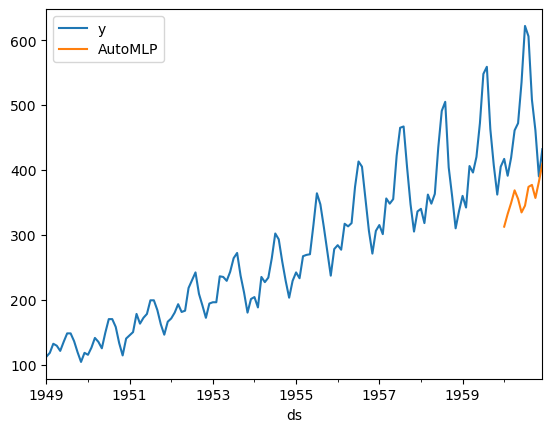

In [11]:
#| hide
Y_test_df['AutoMLP'] = y_hat

pd.concat([Y_train_df, Y_test_df]).drop('unique_id', axis=1).set_index('ds').plot()

In [12]:
#| hide
# Unit tests to guarantee that losses are correctly instantiated
import pandas as pd
from neuralforecast.models.mlp import MLP
from neuralforecast.utils import AirPassengersDF as Y_df
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.losses.pytorch import MSE

Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31']   # 12 test

dataset, *_ = TimeSeriesDataset.from_df(Y_train_df)
config = {
    "hidden_size": tune.choice([512]),
    "num_layers": tune.choice([3, 4]),
    "input_size": 12,
    "max_steps": 1,
    "val_check_steps": 1
}

# Test instantiation
auto = BaseAuto(h=12, loss=MAE(), valid_loss=MSE(), 
                cls_model=MLP, config=config, num_samples=2, cpus=1, gpus=0)
test_eq(str(type(auto.loss)), "<class 'neuralforecast.losses.pytorch.MAE'>")
test_eq(str(type(auto.valid_loss)), "<class 'neuralforecast.losses.pytorch.MSE'>")

# Test validation default
auto = BaseAuto(h=12, loss=MSE(), valid_loss=None,
                cls_model=MLP, config=config, num_samples=2, cpus=1, gpus=0)
test_eq(str(type(auto.loss)), "<class 'neuralforecast.losses.pytorch.MSE'>")
test_eq(str(type(auto.valid_loss)), "<class 'neuralforecast.losses.pytorch.MSE'>")

### References
- [James Bergstra, Remi Bardenet, Yoshua Bengio, and Balazs Kegl (2011). "Algorithms for Hyper-Parameter Optimization". In: Advances in Neural Information Processing Systems. url: https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf](https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)
- [Kirthevasan Kandasamy, Karun Raju Vysyaraju, Willie Neiswanger, Biswajit Paria, Christopher R. Collins, Jeff Schneider, Barnabas Poczos, Eric P. Xing (2019). "Tuning Hyperparameters without Grad Students: Scalable and Robust Bayesian Optimisation with Dragonfly". Journal of Machine Learning Research. url: https://arxiv.org/abs/1903.06694](https://arxiv.org/abs/1903.06694)
- [Lisha Li, Kevin Jamieson, Giulia DeSalvo, Afshin Rostamizadeh, Ameet Talwalkar (2016). "Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization". Journal of Machine Learning Research. url: https://arxiv.org/abs/1603.06560](https://arxiv.org/abs/1603.06560)